In [2]:
from dsc80_utils import *

In [3]:
import importlib, dsc80_utils
importlib.reload(dsc80_utils)    # reloads the module from disk
# If you use explicit names, re-import them AFTER the reload:
from dsc80_utils import make_mcar, make_mar_on_cat  # etc.


In [4]:
# Needed to add renderer for plotting
import plotly.io as pio

# Notebook 7 (new Jupyter) – best bet:
pio.renderers.default = "plotly_mimetype"


# Lecture 8 – Imputation

## DSC 80, Summer 2025

### Announcements 📣


- Lab 4 is due on **Thursday, August 14 at 11:59pm CST**.
- Scores for Lab 1, 2

### Midterm Exam 📝

**Monday, August 18, from 11 - 12:30**

- Covers Lectures 1-8 and all related assignments.
- To review problems from old exams, go to [practice.dsc80.com](https://practice.dsc80.com).
    - More exams coming soon.
- Offered online or on campus
      - Students taking the exam online will be required to use their laptop to video them with paper, pen and upper body all in vision.
- All students may have a note sheet that is both back and front

### Agenda 📆

- Review: Missingness mechanisms.
- Identifying missingness mechanisms in data.
    - How do we decide between MCAR and MAR using a permutation test?
    - The Kolmogorov-Smirnov test statistic.
- Imputation.
    - Mean imputation.
    - Probabilistic imputation.

## Review: Missingness mechanisms

### Flowchart

A good strategy is to assess missingness in the following order.

<center><b>Missing by design (MD)</b></center>
<center><i>Can I determine the missing value exactly by looking at the other columns?</i> 🤔</center>
<center> ⬇️ </center>

<center><b>Not missing at random (NMAR)</b></center>
<center><i>Is there a good reason why the missingness depends on the values themselves?</i> 🤔</center>
<center> ⬇️ </center>

<center><b>Missing at random (MAR)</b></center>
<center><i>Do other columns tell me anything about the likelihood that a value is missing? </i>🤔</center>
<center> ⬇️ </center>

<center><b>Missing completely at random (MCAR)</b></center>
<center><i>The missingness must not depend on other columns or the values themselves. </i>😄</center>

<div class="alert alert-warning">
    <h3>🤔 Breakout!</h3>
</div>

_Taken from the Winter 2023 DSC 80 Midterm Exam._
    
The DataFrame `tv_excl` contains all of the information we have for TV shows that are only available for streaming on a single streaming service.
    
<center>
    <img src="https://practice.dsc80.com/assets/images/wi23-midterm/tv-excl.png" width=40%>
</center>
    
    
Given no other information other than a TV show’s `"Title"` and `"IMDb"` rating, what is the most likely missingness mechanism of the `"IMDb"` column?

- A. Missing by design

- B. Not missing at random

- C. Missing at random

- D. Missing completely at random

<div class="alert alert-warning">
    <h3>Breakout</h3>
</div>

_Taken from the Winter 2023 DSC 80 Midterm Exam._
        
<center>
    <img src="https://practice.dsc80.com/assets/images/wi23-midterm/tv-excl.png" width=40%>
</center>
    
    
Now, suppose we discover that the median `"Rotten Tomatoes"` rating among TV shows with a missing `"IMDb"` rating is a 13, while the median `"Rotten Tomatoes"` rating among TV shows with a present `"IMDb"` rating is a 52.

Given this information, what is the most likely missingness mechanism of the `"IMDb"` column?

- A. Missing by design

- B. Not missing at random

- C. Missing at random

- D. Missing completely at random

## Identifying missingness mechanisms in data

### Example: Heights

- Let's load in Galton's dataset containing the heights of adult children and their parents (which you may have seen in DSC 10).
- The dataset does not contain any missing values – we will **artifically introduce missing values** such that the values are MCAR, for illustration.

In [5]:
heights_path = Path('data') / 'midparent.csv'
heights = pd.read_csv(heights_path).rename(columns={'childHeight': 'child'})[['father', 'mother', 'gender', 'child']]
heights.head()

,father,mother,gender,child
0,78.5,67.0,male,73.2
1,78.5,67.0,female,69.2
2,78.5,67.0,female,69.0
3,78.5,67.0,female,69.0
4,75.5,66.5,male,73.5


### Simulating MCAR data

- We will make `'child'` MCAR by taking a random subset of `heights` and setting the corresponding `'child'` heights to `np.NaN`.
- This is equivalent to flipping a (biased) coin for each row. 
    - If heads, we delete the `'child'` height.
- **You will not do this in practice!**

In [6]:
np.random.seed(42) # So that we get the same results each time (for lecture).

heights_mcar = heights.copy()
idx = heights_mcar.sample(frac=0.3).index
heights_mcar.loc[idx, 'child'] = np.nan

In [7]:
heights_mcar.head(10)

,father,mother,gender,child
0,78.5,67.0,male,73.2
1,78.5,67.0,female,69.2
2,78.5,67.0,female,NaN
...,...,...,...,...
7,75.5,66.5,female,NaN
8,75.0,64.0,male,71.0
9,75.0,64.0,female,68.0


In [8]:
heights_mcar.isna().mean()

father    0.0
mother    0.0
gender    0.0
child     0.3
dtype: float64

### Verifying that child heights are MCAR in `heights_mcar`

- Each row of `heights_mcar` belongs to one of two **groups**:
    - Group 1: `'child'` is missing.
    - Group 2: `'child'` is not missing.

In [9]:
heights_mcar['child_missing'] = heights_mcar['child'].isna()
heights_mcar.head()

,father,mother,gender,child,child_missing
0,78.5,67.0,male,73.2,False
1,78.5,67.0,female,69.2,False
2,78.5,67.0,female,NaN,True
3,78.5,67.0,female,69.0,False
4,75.5,66.5,male,73.5,False


- We need to look at the distributions of every other column – `'gender'`, `'mother'`, and `'father'` – separately for these two groups, and check to see if they are similar.

In [10]:
gender_dist = (
    heights_mcar
    .assign(child_missing=heights_mcar['child'].isna())
    .pivot_table(index='gender', columns='child_missing', aggfunc='size')
)

# Added just to make the resulting pivot table easier to read.
gender_dist.columns = ['child_missing = False', 'child_missing = True']

gender_dist = gender_dist / gender_dist.sum()
gender_dist

,child_missing = False,child_missing = True
gender,,
female,0.49,0.48
male,0.51,0.52


In [13]:
# Needed to add renderer
import plotly.io as pio

# Notebook 7 (new Jupyter) – best bet:
pio.renderers.default = "plotly_mimetype"


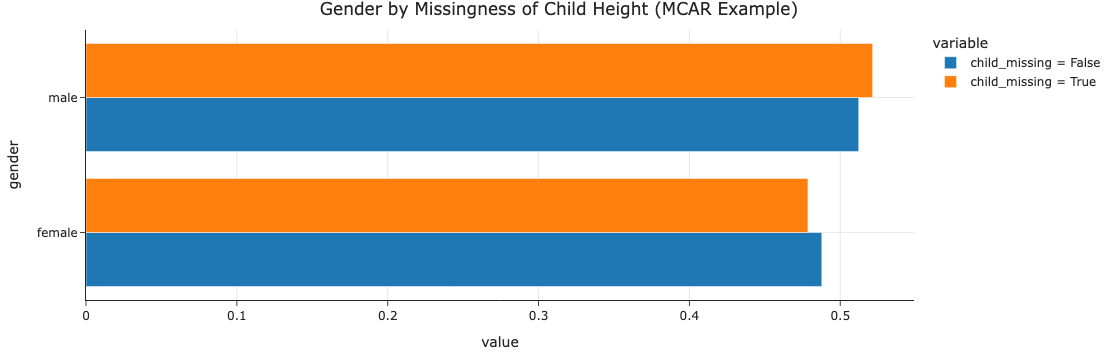

In [14]:
gender_dist.plot(kind='barh', title='Gender by Missingness of Child Height (MCAR Example)', barmode='group')

Since `'gender'` is categorical, we're looking at two categorical variables here. The two distributions look similar, but to make formal what we mean by similar, we'd need to run a permutation test.

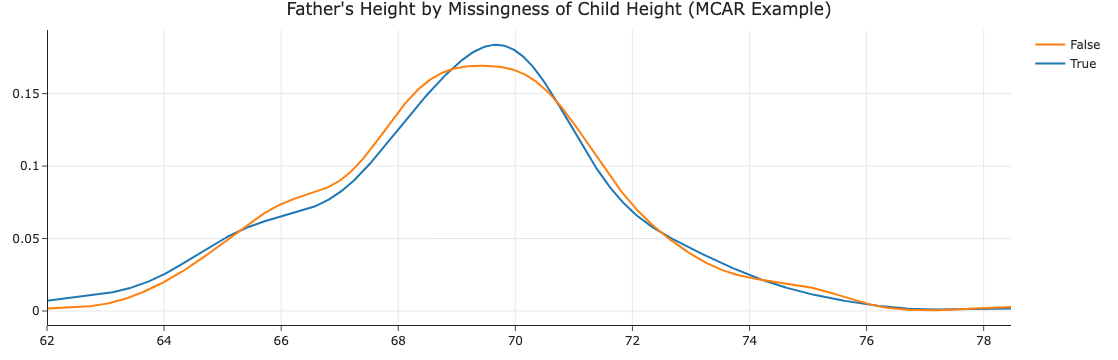

In [15]:
create_kde_plotly(heights_mcar, 'child_missing', True, False, 'father', 
                  "Father's Height by Missingness of Child Height (MCAR Example)")

Since `'father'`s heights are numerical, we're looking at two numerical variables here. The two distributions look similar, but to make formal what we mean by similar, we'd need to run a permutation test.

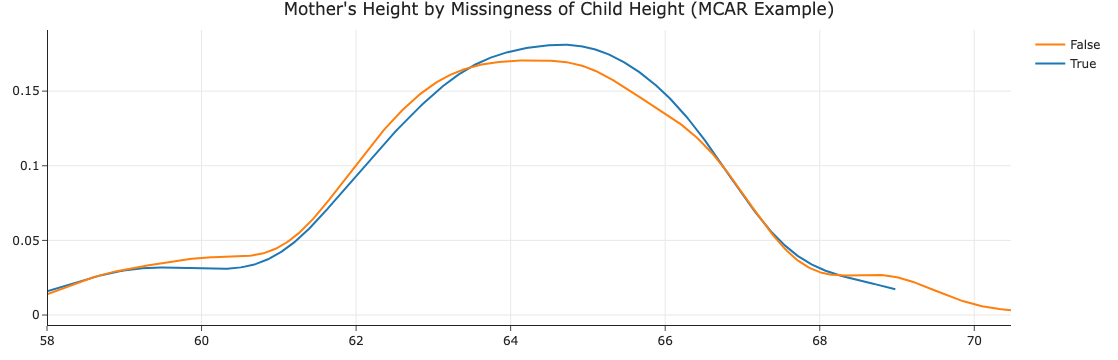

In [16]:
create_kde_plotly(heights_mcar, 'child_missing', True, False, 'mother', 
                  "Mother's Height by Missingness of Child Height (MCAR Example)")

Again, `'mother'`s heights are numerical, we're looking at two numerical variables here. The two distributions look similar, but to make formal what we mean by similar, we'd need to run a permutation test.

### Concluding that `'child'` is MCAR

- We need to run three permutation tests – one for each column in `heights_mcar` other than `'child'`.

- For every other column, if we **fail to reject the null** that the distribution of the column when `'child'` is missing is the same as the distribution of the column when `'child'` is not missing, then we can conclude `'child'` is MCAR.
    - In such a case, its missingness is not tied to any other columns.
    - For instance, children with shorter fathers are not any more likely to have missing heights than children with taller fathers.

### Simulating MAR data

Now, we will make `'child'` heights MAR by deleting `'child'` heights according to a random procedure that **depends on other columns**.

In [13]:
np.random.seed(42) # So that we get the same results each time (for lecture).

def make_missing(r):
    rand = np.random.uniform() # Random real number between 0 and 1.
    if r['father'] > 72 and rand < 0.5:
        return np.nan
    elif r['gender'] == 'female' and rand < 0.3:
        return np.nan
    else:
        return r['child']
    
heights_mar = heights.copy()
heights_mar['child'] = heights_mar.apply(make_missing, axis=1)
heights_mar['child_missing'] = heights_mar['child'].isna()

In [14]:
heights_mar.head()

,father,mother,gender,child,child_missing
0,78.5,67.0,male,NaN,True
1,78.5,67.0,female,69.2,False
2,78.5,67.0,female,69.0,False
3,78.5,67.0,female,69.0,False
4,75.5,66.5,male,NaN,True


### Comparing null and non-null `'child'` distributions for `'gender'`, again

This time, the distribution of `'gender'` in the two groups is very different.

In [15]:
gender_dist = (
    heights_mar
    .assign(child_missing=heights_mar['child'].isna())
    .pivot_table(index='gender', columns='child_missing', aggfunc='size')
)

# Added just to make the resulting pivot table easier to read.
gender_dist.columns = ['child_missing = False', 'child_missing = True']

gender_dist = gender_dist / gender_dist.sum()
gender_dist

,child_missing = False,child_missing = True
gender,,
female,0.4,0.88
male,0.6,0.12


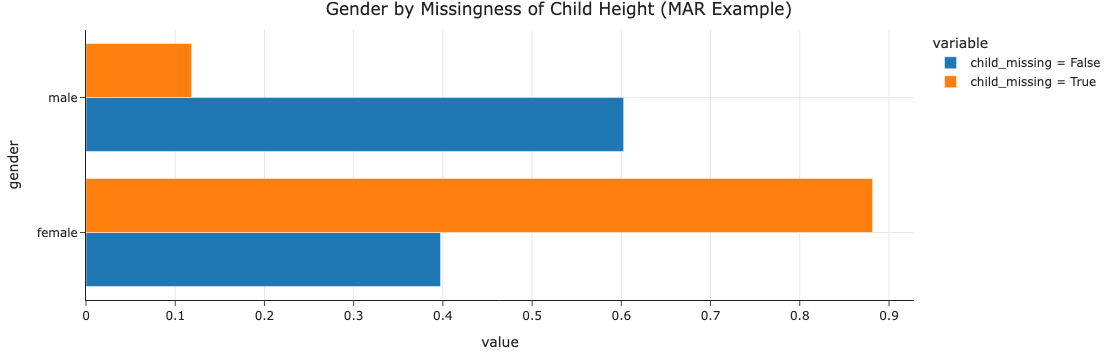

In [21]:
gender_dist.plot(kind='barh', title='Gender by Missingness of Child Height (MAR Example)', barmode='group')

### Comparing null and non-null `'child'` distributions for `'father'`, again

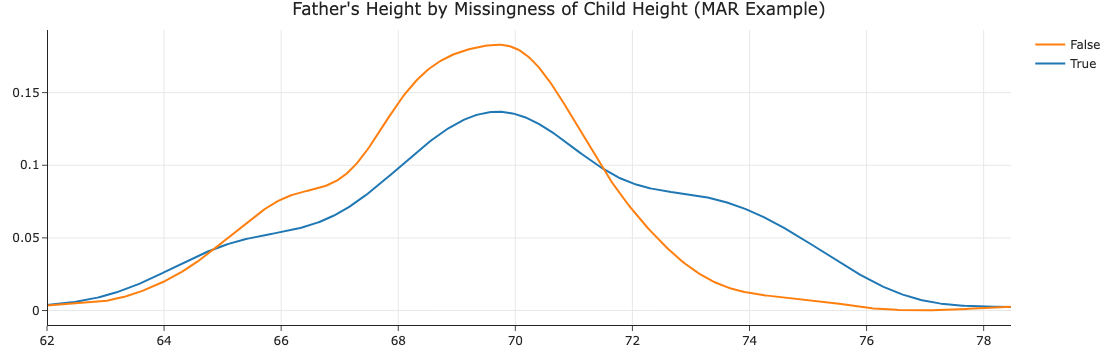

In [22]:
create_kde_plotly(heights_mar, 'child_missing', True, False, 'father', 
                  "Father's Height by Missingness of Child Height (MAR Example)")

- The above two distributions look quite different.
    - This is because we artificially created missingness in the dataset in a way that depended on `'father'` and `'gender'`.

- However, their difference in means is small:

In [23]:
(
    heights_mar
    .groupby('child_missing')
    ['father']
    .mean()
    .diff()
    .iloc[-1]
)

np.float64(1.0055466604787853)

- If we ran a permutation test with the difference in means as our test statistic, we would fail to reject the null.
    - **Using just the difference in means, it is hard to tell these two distributions apart.**

## The Kolmogorov-Smirnov test statistic

### Recap: Permutation tests

- Permutation tests help decide whether **two samples look like they were drawn from the same population distribution**.

- In a permutation test, we simulate data under the null by **shuffling** either group labels or numerical features.
    - In effect, this **randomly assigns individuals to groups**.

- If the two distributions are **numerical**, we've used as our test statistic the **difference in group means or medians**.

- If the two distributions are **categorical**, we've used as our test statistic the **total variation distance (TVD)**.

### Difference in means

The difference in means works well in some cases. Let's look at one such case.

Below, we artificially generate two numerical datasets.

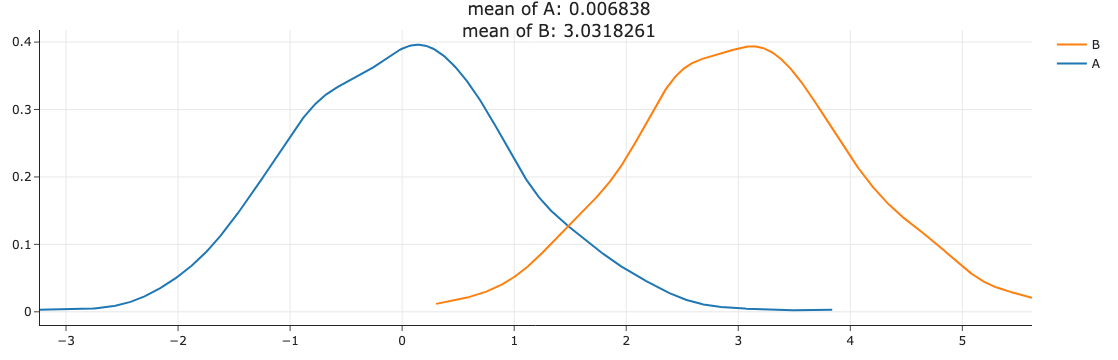

In [24]:
np.random.seed(42) # So that we get the same results each time (for lecture).

N = 1000 # Number of samples for each distribution.

# Distribution 'A'.
distr1 = pd.Series(np.random.normal(0, 1, size=N // 2))

# Distribution 'B'.
distr2 = pd.Series(np.random.normal(3, 1, size=N // 2))

data = pd.concat([distr1, distr2], axis=1, keys=['A', 'B']).unstack().reset_index().drop('level_1', axis=1)
data = data.rename(columns={'level_0': 'group', 0: 'data'})

meanA, meanB = data.groupby('group')['data'].mean().round(7).tolist()
create_kde_plotly(data, 'group', 'A', 'B', 'data', f'mean of A: {meanA}<br>mean of B: {meanB}')

### Different distributions with the same mean

Let's generate two distributions that look very different but have the same mean.

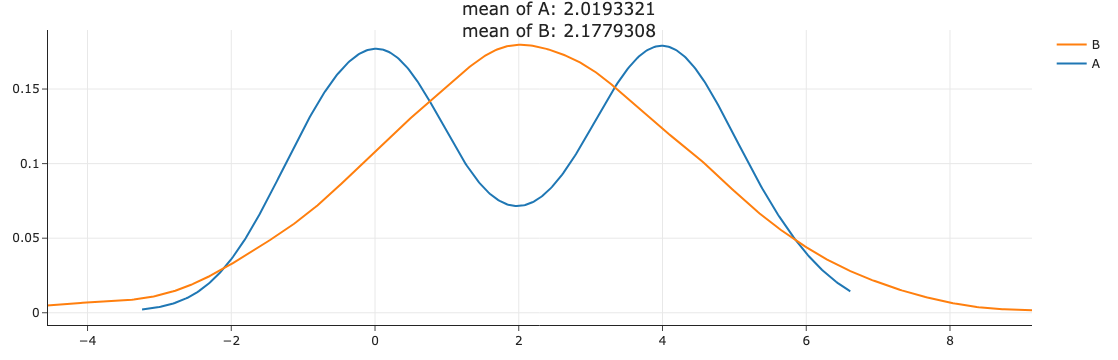

In [25]:
np.random.seed(42) # So that we get the same results each time (for lecture).

N = 1000 # Number of samples for each distribution.

# Distribution 'A'.
a = pd.Series(np.random.normal(0, 1, size=N//2))
b = pd.Series(np.random.normal(4, 1, size=N//2))
distr1 = pd.concat([a,b], ignore_index=True)

# Distribution 'B'.
distr2 = pd.Series(np.random.normal(distr1.mean(), distr1.std(), size=N))

data = pd.concat([distr1, distr2], axis=1, keys=['A', 'B']).unstack().reset_index().drop('level_1', axis=1)
data = data.rename(columns={'level_0': 'group', 0: 'data'})

meanA, meanB = data.groupby('group')['data'].mean().round(7).tolist()
create_kde_plotly(data, 'group', 'A', 'B', 'data', f'mean of A: {meanA}<br>mean of B: {meanB}')

In this case, if we use the difference in means as our test statistic in a permutation test, we will fail to reject the null that the two distributions are different.

In [26]:
n_repetitions = 500
shuffled = data.copy()

diff_means = []
for _ in range(n_repetitions):
    
    # Shuffling the values, while keeping the group labels in place.
    shuffled['data'] = np.random.permutation(shuffled['data'])
    
    # Computing and storing the absolute difference in means.
    diff_mean = shuffled.groupby('group')['data'].mean().diff().abs().iloc[-1]
    diff_means.append(diff_mean)

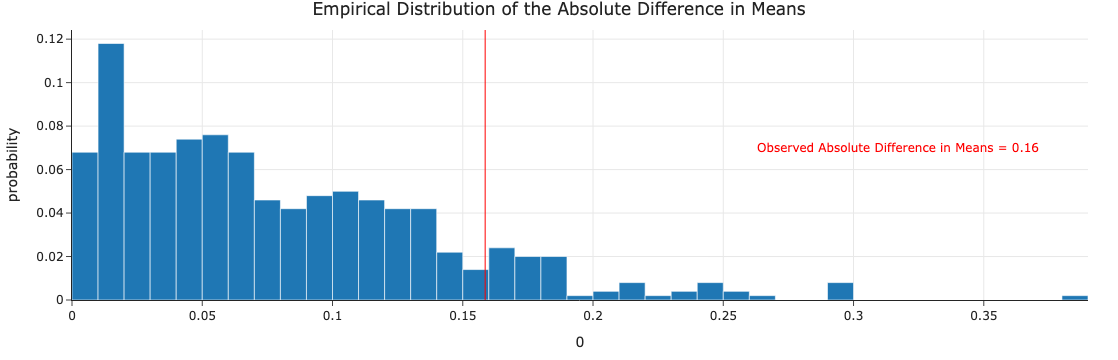

In [27]:
observed_diff = data.groupby('group')['data'].mean().diff().abs().iloc[-1]
fig = px.histogram(pd.DataFrame(diff_means), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the Absolute Difference in Means')
fig.add_vline(x=observed_diff, line_color='red', line_width=1, opacity=1)
fig.add_annotation(text=f'<span style="color:red">Observed Absolute Difference in Means = {round(observed_diff, 2)}</span>',
                   x=2 * observed_diff, showarrow=False, y=0.07)

In [28]:
# The computed p-value is fairly large.
np.mean(np.array(diff_means) >= observed_diff)

np.float64(0.108)

### Telling numerical distributions apart

- The difference in means only works as a test statistic in permutation tests **if the two distributions have similar shapes**.
    - It tests to see if one is a shifted version of the other.

- We need a better test statistic to differentiate between numerical distributions with different shapes.

- In other words, we need a **distance** metric between numerical.
    - The TVD is a distance metric between categorical distributions.

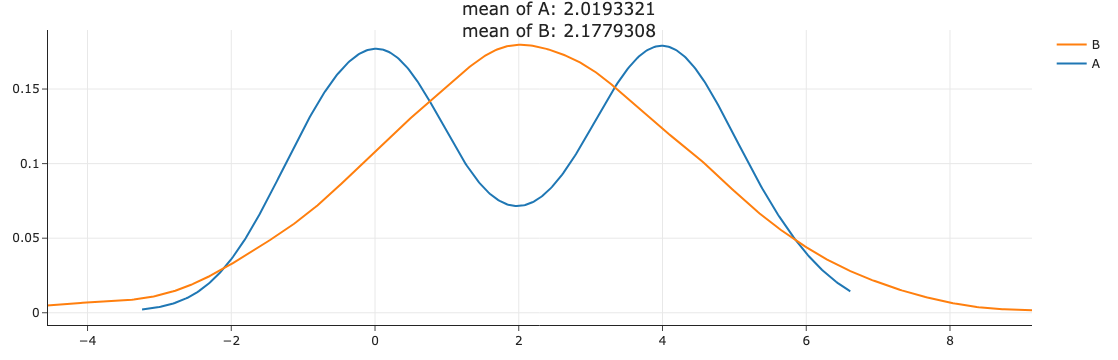

In [29]:
create_kde_plotly(data, 'group', 'A', 'B', 'data', f'mean of A: {meanA}<br>mean of B: {meanB}')

### The Kolmogorov-Smirnov test statistic

- The K-S test statistic measures the similarity between two distributions.
- It is defined in terms of the **cumulative distribution function (CDF)** of a given distribution.
    - If $f(x)$ is a distribution, then the CDF $F(x)$ is the proportion of values in distribution $f$ that are less than or equal to $x$.
- The K-S statistic is roughly defined as the **largest difference between two CDFs**.
<center><img src=./imgs/KS2_Example.png width=50%></center>

### Aside: Cumulative distribution functions

First, some setup.

In [39]:
fig1 = create_kde_plotly(data, 'group', 'A', 'B', 'data', f'Distributions of A and B')

# Think about what this function is doing!
def create_cdf(group):
    return data.loc[data['group'] == group, 'data'].value_counts(normalize=True).sort_index().cumsum()

fig2 = go.Figure()

fig2.add_trace(
    go.Scatter(x=create_cdf('A').index, y=create_cdf('A'), name='CDF of A')
)

fig2.add_trace(
    go.Scatter(x=create_cdf('B').index, y=create_cdf('B'), name='CDF of B')
)

fig2.update_layout(title='CDFs of A and B')

from plotly.subplots import make_subplots

for i in range(2):
    fig2.data[i]['marker']['color'] = fig1.data[i]['marker']['color']
    fig2.data[i]['showlegend'] = False
    
fig = make_subplots(rows=1, cols=2, subplot_titles=['Distributions', 'CDFs'])
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig1.data[1], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)
fig.add_trace(fig2.data[1], row=1, col=2)
fig.update_layout(width=1000, height=400);

### Aside: Cumulative distribution functions

Let's look at the CDFs of our two synthetic distributions.

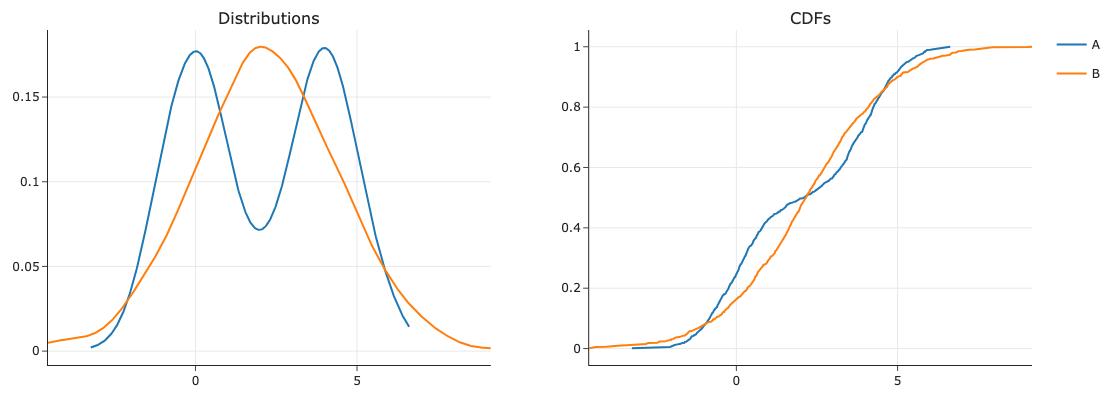

In [40]:
fig

### The K-S statistic in Python

Fortunately, **we don't need to calculate the K-S statistic ourselves**! Python can do it for us (and you can use this pre-built version in all assignments).

In [41]:
from scipy.stats import ks_2samp

In [42]:
ks_2samp?

Signature:
ks_2samp(
    data1,
    data2,
    alternative='two-sided',
    method='auto',
    *,
    axis=0,
    nan_policy='propagate',
    keepdims=False,
)
Docstring:
Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.

This test compares the underlying continuous distributions F(x) and G(x)
of two independent samples.  See Notes for a description of the available
null and alternative hypotheses.

Parameters
----------
data1, data2 : array_like, 1-Dimensional
    Two arrays of sample observations assumed to be drawn from a continuous
    distribution, sample sizes can be different.
alternative : {'two-sided', 'less', 'greater'}, optional
    Defines the null and alternative hypotheses. Default is 'two-sided'.
    Please see explanations in the Notes below.
method : {'auto', 'exact', 'asymp'}, optional
    Defines the method used for calculating the p-value.
    The following options are available (default is 'auto'):
    
      * 'auto' : use 'exact' for small size

In [55]:
observed_ks = ks_2samp(data.loc[data['group'] == 'A', 'data'], data.loc[data['group'] == 'B', 'data']).statistic
observed_ks

np.float64(0.14)

We don't know if this number is big or small. We need to run a permutation test!

In [56]:
n_repetitions = 500
shuffled = data.copy()

ks_stats = []
for _ in range(n_repetitions):
    
    # Shuffling the data.
    shuffled['data'] = np.random.permutation(shuffled['data'])
    
    # Computing and storing the K-S statistic.
    groups = shuffled.groupby('group')['data']
    ks_stat = ks_2samp(groups.get_group('A'), groups.get_group('B')).statistic
    ks_stats.append(ks_stat)
    
ks_stats[:10]

[np.float64(0.027),
 np.float64(0.052),
 np.float64(0.027),
 np.float64(0.021),
 np.float64(0.045),
 np.float64(0.04),
 np.float64(0.045),
 np.float64(0.019),
 np.float64(0.028),
 np.float64(0.039)]

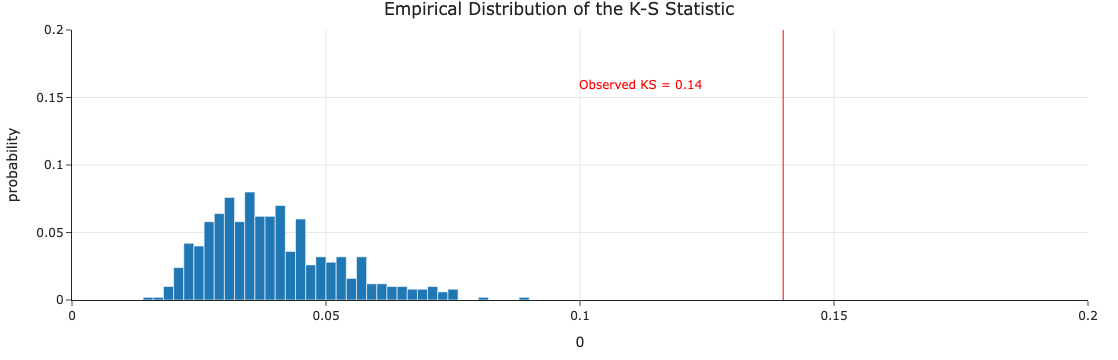

In [57]:
fig = px.histogram(pd.DataFrame(ks_stats), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the K-S Statistic')
fig.add_vline(x=observed_ks, line_color='red', line_width=1, opacity=1)
fig.add_annotation(text=f'<span style="color:red">Observed KS = {round(observed_ks, 2)}</span>',
                   x=0.8 * observed_ks, showarrow=False, y=0.16)

fig.update_layout(xaxis_range=[0, 0.2])
fig.update_layout(yaxis_range=[0, 0.2])

In [58]:
np.mean(np.array(ks_stats) >= observed_ks)

np.float64(0.0)

We were able to differentiate between the two distributions using the K-S test statistic!

### `ks_2samp`

* `scipy.stats.ks_2samp` actually returns **both** the statistic **and** a p-value.
* The p-value is calculated using the permutation test we just performed!

In [59]:
ks_2samp(data.loc[data['group'] == 'A', 'data'], data.loc[data['group'] == 'B', 'data'])

KstestResult(statistic=np.float64(0.14), pvalue=np.float64(5.822752148022591e-09), statistic_location=np.float64(0.9755451271223592), statistic_sign=np.int8(1))

### Difference in means vs. K-S statistic

- The K-S statistic measures the difference between two numerical distributions.

- It **does not** quantify if one is larger than the other on average, so there are times we still need to use the difference in means.


- Strategy: Always plot the two distributions you are comparing.
    - If the distributions have similar shapes but are centered in different places, use the difference in means (or absolute difference in means).
    - If your alternative hypothesis involves a "direction" (i.e. smoking weights were are on average than non-smoking weights), use the difference in means.
    - If the distributions have different shapes but roughly the same center, and your alternative hypothesis is simply that the two distributions are different, use the K-S statistic.

### Back to our Example: Missingness of `'child'` heights on `'father'`'s heights (MAR)

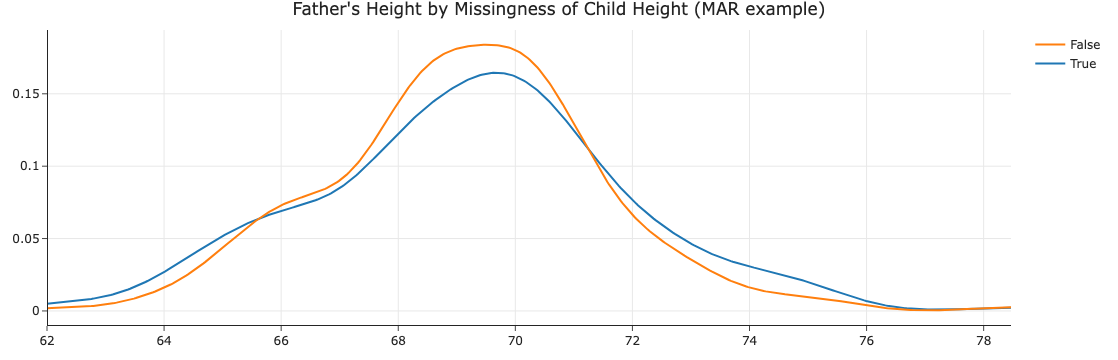

In [74]:
heights_mar['child_missing'] = heights_mar['child'].isna()
create_kde_plotly(heights_mar[['child_missing', 'father']], 'child_missing', True, False, 'father',
                       "Father's Height by Missingness of Child Height (MAR example)")

- The above picture shows us that missing `'child'` heights tend to come from taller `'father'`s heights.

- To determine whether the two distributions are significantly different, we must use a permutation test. This time, the difference in means is not a good choice, since the centers are similar but the shapes are different.

### Performing the test

In [61]:
heights_mar

,father,mother,gender,child,child_missing
0,78.5,67.0,male,NaN,True
1,78.5,67.0,female,69.2,False
2,78.5,67.0,female,69.0,False
...,...,...,...,...,...
931,62.0,66.0,female,61.0,False
932,62.5,63.0,male,66.5,False
933,62.5,63.0,female,57.0,False


In [62]:
ks_2samp(heights_mar.query('child_missing')['father'], heights_mar.query('not child_missing')['father'])

KstestResult(statistic=np.float64(0.20676025834396874), pvalue=np.float64(1.1424922868036869e-05), statistic_location=np.float64(72.0), statistic_sign=np.int8(-1))

**The p-value is very small, so we conclude that the child height is MAR, conditional on the father's height.**

## Handling missing values

### What do we do with missing data?

- Suppose we are interested in a dataset $Y$. 
- We get to **observe** $Y_{obs}$, while the rest of the dataset, $Y_{mis}$, is **missing**.
- Issue: $Y_{obs}$ may look quite different than $Y$.
    - The mean and other measures of central tendency may be different.
    - The variance may be different.
    - The correlations between variables may be different.

### Solution 1: Dropping missing values

- If the data are MCAR (missing completely at random), then dropping the missing values entirely doesn't significantly change the data.
    - For instance, the mean of the dataset post-dropping is an unbiased estimate of the true mean.
    - This is because MCAR data is a **random sample** of the full dataset.
    - From DSC 10, we know that random samples tend to resemble the larger populations they are drawn from.

- **If the data are not MCAR, then dropping the missing values will introduce bias.**
    - MCAR is rare!
    - For instance, suppose we asked people "How much do you give to charity?" People who give little are less likely to respond, so the average response is **biased high**.

### Listwise deletion

- _Listwise deletion_ is the act of dropping entire rows that contain missing values.
- Issue: This can delete perfectly good data in other columns for a given row.
    - Improvement: Drop missing data only when working with the column that contains missing data.

To illustrate, let's generate two datasets with missing `'child'` heights – one in which the heights are MCAR, and one in which they are MAR dependent on `'gender'` only.

**In practice, you'll have to run permutation tests to determine the likely missingness mechanism first!**

In [68]:
np.random.seed(42) # So that we get the same results each time (for lecture).
heights_mcar = make_mcar(heights, 'child', pct=0.5)
heights_mar = make_mar_on_cat(heights, 'child', 'gender', pct=0.5)

### Listwise deletion

Below, we compute the means and standard deviations of the `'child'` column in all three datasets. Remember, `.mean()` and `.std()` ignore missing values.

In [69]:
multiple_describe({
    'Original': heights,
    'MCAR': heights_mcar,
    'MAR': heights_mar
})

,Mean,Standard Deviation
Dataset,,
Original,66.75,3.58
MCAR,66.64,3.56
MAR,68.52,3.12


Observations:

- The `'child'` mean (and SD) in the MCAR dataset is very close to the true `'child'` mean (and SD).

- The `'child'` mean in the MAR dataset is biased **high**.

### Solution 2: Imputation

**Imputation** is the act of filling in missing data with plausable values. Ideally, imputation:

* is quick and easy to do.
* shouldn't introduce bias into the dataset.

These are hard to do at the same time!

### Kinds of imputation

- There are three main types of imputation, two of which we will focus on today:

    - **Imputation with a single value: mean, median, mode.**
    - Imputation with a single value, using a model: regression, kNN.
    - **Probabilistic imputation by drawing from a distribution.**

- Each has upsides and downsides, and **each works differently with different types of missingness**.

## Mean imputation

### Mean imputation

- Mean imputation is the act of filling in missing values in a column with the mean of the observed values in that column.
- This strategy:
    - 👍 Preserves the mean of the observed data, for all types of missingness.
    - 👎 Decreases the variance of the data, for all types of missingness.
    - 👎 Creates a biased estimate of the true mean when the data are not MCAR.

### Example: Mean imputation in the MCAR `heights` dataset

Let's look at two distributions:
- The distribution of the `'child'` column in `heights`, where we have all the data.
- The distribution of the `'child'` column in `heights_mcar`, where some values are MCAR.

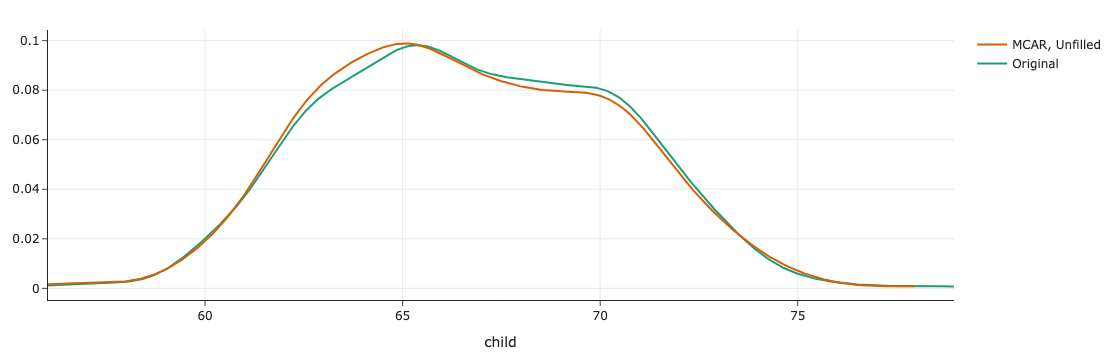

In [73]:
# Look in util.py to see how multiple_kdes is defined.
multiple_kdes({'Original': heights, 'MCAR, Unfilled': heights_mcar})

- Since the `'child'` heights are MCAR, the <span style='color:rgb(217,95,2)'><b> orange distribution, in which some values are missing</b></span>, has roughly the same shape as the <span style='color:rgb(27,158,119)'><b>turquoise distribution, which has no missing values</b></span>.

### Mean imputation of MCAR data

Let's fill in missing values in `heights_mcar['child']` with the mean of the observed `'child'` heights in `heights_mcar['child']`.

In [75]:
heights_mcar['child'].head()

0    73.2
1    69.2
2     NaN
3     NaN
4    73.5
Name: child, dtype: float64

In [76]:
heights_mcar_mfilled = heights_mcar.fillna(heights_mcar['child'].mean())
heights_mcar_mfilled['child'].head()

0    73.20
1    69.20
2    66.64
3    66.64
4    73.50
Name: child, dtype: float64

In [77]:
df_map = {'Original': heights, 'MCAR, Unfilled': heights_mcar, 'MCAR, Mean Imputed': heights_mcar_mfilled}
multiple_describe(df_map)

,Mean,Standard Deviation
Dataset,,
Original,66.75,3.58
"MCAR, Unfilled",66.64,3.56
"MCAR, Mean Imputed",66.64,2.52


Observations:

- The mean of the imputed dataset is the same as the mean of the subset of heights that aren't missing (which is close to the true mean).

- The standard deviation of the imputed dataset smaller than that of the other two datasets. **Why?**

### Mean imputation of MCAR data

Let's visualize all three distributions: the original, the MCAR heights with missing values, and the mean-imputed MCAR heights.

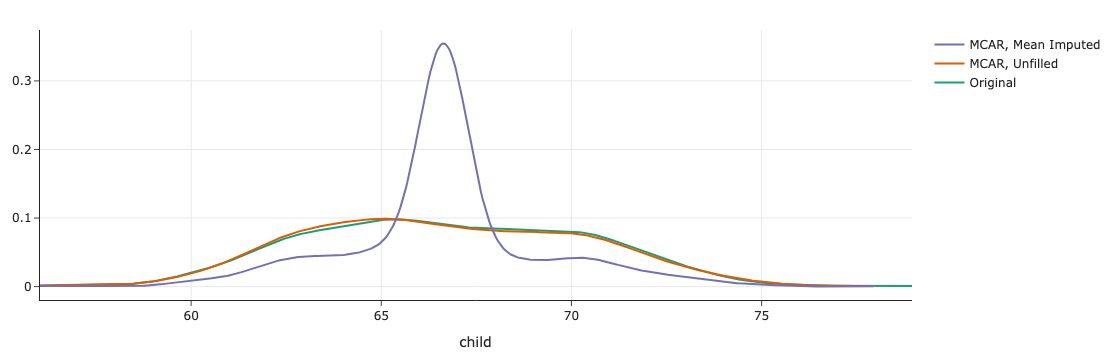

In [78]:
multiple_kdes(df_map)

**Takeaway**: When data are MCAR and you impute with the mean:
- The mean of the imputed dataset is an **unbiased estimator** of the true mean.
- The variance of the imputed dataset is smaller than the variance of the full dataset.
    - Mean imputation tricks you into thinking your data are more reliable than they are!

### Example: Mean imputation in the MAR `heights` dataset

- When data are MAR, mean imputation leads to biased estimates of the mean across groups.

- The bias may be different in different groups.
    - For example: If the missingness depends on gender, then different genders will have differently-biased means.
    - The overall mean will be biased towards one group.

- Again, let's look at two distributions:
    - The distribution of the `'child'` column in `heights`, where we have all the data.
    - The distribution of the `'child'` column in `heights_mar`, where some values are MAR.

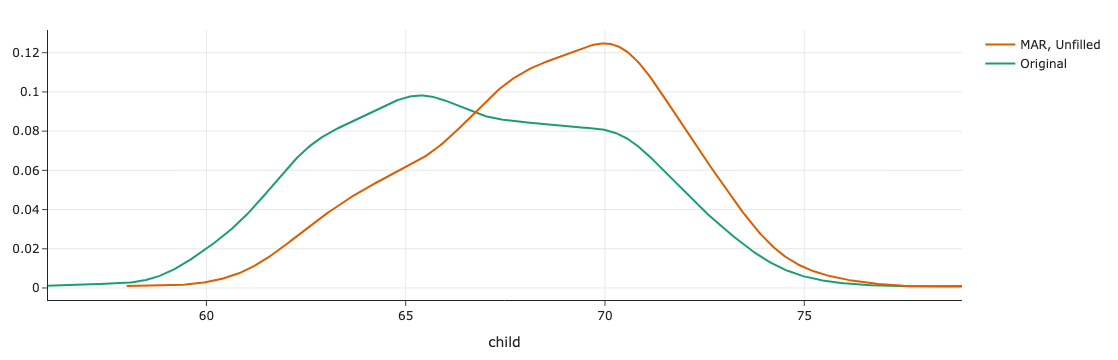

In [79]:
multiple_kdes({'Original': heights, 'MAR, Unfilled': heights_mar})

The distributions are not very similar!

Remember that in reality, you won't get to see the <span style='color:rgb(27,158,119)'><b>turquoise distribution, which has no missing values</b></span> – instead, you'll try to recreate it, using your sample with missing values.

### Mean imputation of MAR data

Let's fill in missing values in `heights_mar['child']` with the mean of the observed `'child'` heights in `heights_mar['child']` and see what happens.

In [80]:
heights_mar['child'].head()

0    73.2
1    69.2
2     NaN
3     NaN
4    73.5
Name: child, dtype: float64

In [81]:
heights_mar_mfilled = heights_mar.fillna(heights_mar['child'].mean())
heights_mar_mfilled['child'].head()

0    73.20
1    69.20
2    68.52
3    68.52
4    73.50
Name: child, dtype: float64

In [82]:
df_map = {'Original': heights, 'MAR, Unfilled': heights_mar, 'MAR, Mean Imputed': heights_mar_mfilled}
multiple_describe(df_map)

,Mean,Standard Deviation
Dataset,,
Original,66.75,3.58
"MAR, Unfilled",68.52,3.12
"MAR, Mean Imputed",68.52,2.20


Note that the latter two means are biased **high**.

### Mean imputation of MAR data

Let's visualize all three distributions: the original, the MAR heights with missing values, and the mean-imputed MAR heights.

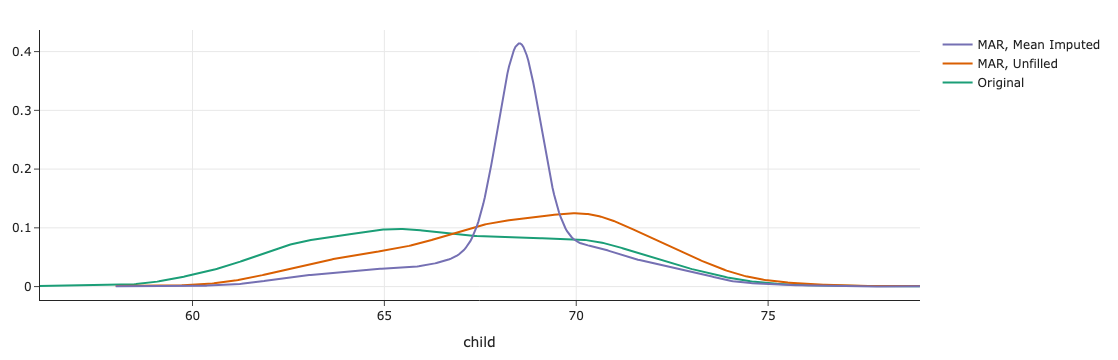

In [83]:
multiple_kdes(df_map)

Since the sample with MAR values was already biased high, mean imputation kept the sample biased – it did not bring the data **closer to the data generating process**.

With our single mean imputation strategy, the resulting female mean height is biased quite high.

In [95]:
pd.concat([
    heights.groupby('gender')['child'].mean().rename('Original'),
    heights_mar.groupby('gender')['child'].mean().rename('MAR, Unfilled'),
    heights_mar_mfilled.groupby('gender')['child'].mean().rename('MAR, Mean Imputed')
], axis=1).T

gender,female,male
Original,64.10,69.23
"MAR, Unfilled",64.22,69.28
"MAR, Mean Imputed",67.85,69.14


### Within-group (conditional) mean imputation

* **Improvement**: Since MAR data are MCAR within each group, we can perform group-wise mean imputation.
    - In our case, since the missingness of `'child'` is dependent on `'gender'`, we can impute separately for each `'gender'`.
    - For instance, if there is a missing `'child'` height for a `'female'` child, impute their height with the mean observed `'female'` height.

- With this technique, the overall mean remains unbiased, as do the within-group means.

- Like with "single" mean imputation, the variance of the dataset is reduced.

### `transform` returns!

- In MAR data, imputation by the overall mean gives a biased estimate of the mean of each group. 
- To obtain an unbiased estimate of the mean within each group, impute using the mean within each group.
- To perform an operation separately to each gender, we `groupby('gender')` and use the `transform` method.

In [85]:
def mean_impute(s):
    return s.fillna(s.mean())

heights_mar_cond = heights_mar.groupby('gender')['child'].transform(mean_impute).to_frame()
heights_mar_cond['child'].head()

0    73.20
1    69.20
2    64.22
3    64.22
4    73.50
Name: child, dtype: float64

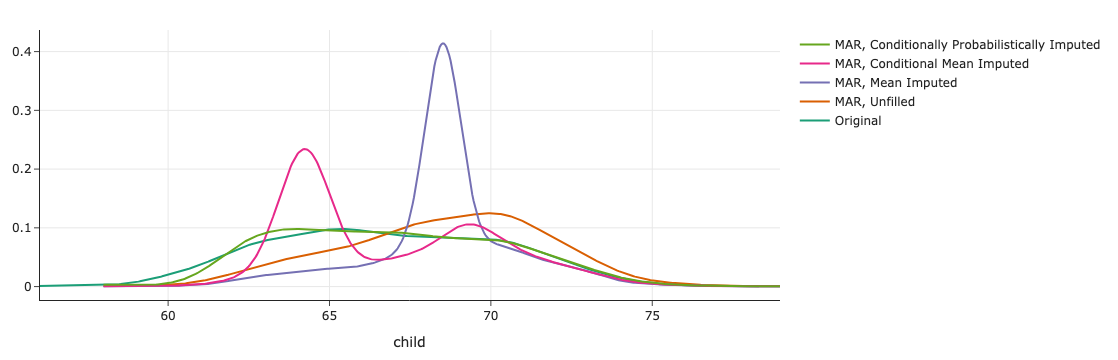

In [90]:
df_map['MAR, Conditional Mean Imputed'] = heights_mar_cond
multiple_kdes(df_map)

In [92]:
type(df_map)

dict

The <span style='color:rgb(231,41,138)'><b>pink distribution</b></span> does a slightly better job of approximating the <span style='color:rgb(27,158,119)'><b>turquoise distribution</b></span> than the <span style='color:rgb(117,112,179)'><b>purple distribution</b></span>, but not by much.

### Conclusion: Imputation with single values

- Imputing missing data in a column with the mean of the column:
    - faithfully reproduces the mean of the observed dataset,
    - reduces the variance, and
    - biases relationships between the column and other columns if the data are not MCAR.
    
- The same is true with other statistics (e.g. median and mode).

## Probabilistic imputation

### Imputing missing values using distributions

- So far, each missing value in a column has been filled in with a constant value.
    - This creates "spikes" in the imputed distributions.

- **Idea**: We can **probabilistically** impute missing data from a distribution.
    - We can fill in missing data by drawing from the distribution of the **non-missing** data.
    - There are 5 missing values? Pick 5 values from the data that aren't missing.
     - How? Using `np.random.choice` or `.sample`.

- If the data are MCAR, then sample from the entire column of present values. If the data are MAR on some categorical column, then sample from the present values separately for each category.

### Example: Probabilistic imputation in the MAR `heights` dataset

Let's use `transform` to call `prob_impute` separately on each `'gender'`.

In [87]:
def prob_impute(s):
    s = s.copy()
    
    # Step 1: Find the number of missing child heights for that gender.
    num_null = s.isna().sum()
    
    # Step 2: Sample num_null observed child heights for that gender.
    fill_values = np.random.choice(s.dropna(), num_null)
    
    # Step 3: Fill in missing values and return ser.
    s[s.isna()] = fill_values
    return s

In [88]:
heights_mar_pfilled = heights_mar.copy()
heights_mar_pfilled['child'] = (
    heights_mar
    .groupby('gender')
    ['child']
    .transform(prob_impute)
)
heights_mar_pfilled['child'].head()

0    73.2
1    69.2
2    62.0
3    62.5
4    73.5
Name: child, dtype: float64

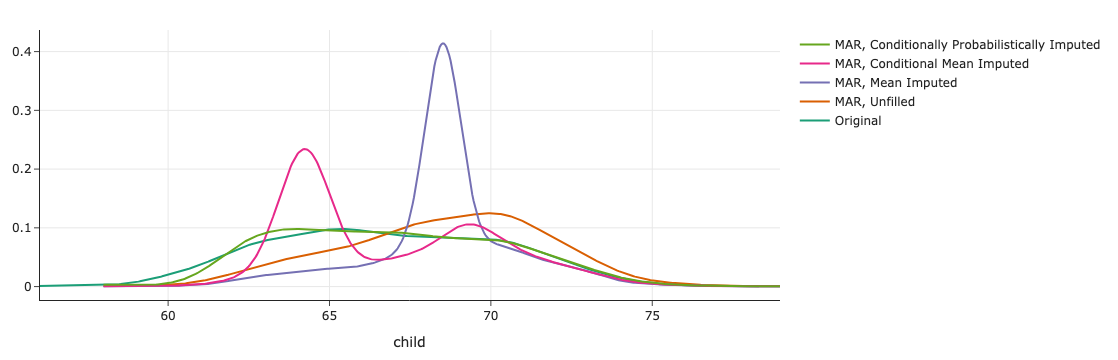

In [89]:
df_map['MAR, Conditionally Probabilistically Imputed'] = heights_mar_pfilled
multiple_kdes(df_map)

The <b><span style="color:#67a61f">green distribution (conditional probabilistic imputation)</span></b> does the best job of approximating the <b><span style="color:#1c9e76">turqoise distribution (the full dataset with no missing values)</span></b>!

_Remember that the graph above is interactive – you can hide/show lines by clicking them in the legend._

### Observations

- With this technique, the missing values were filled in with observed values in the dataset.

- If a value was never observed in the dataset, it will never be used to fill in a missing value.
    - For instance, if the observed heights were 68, 69, and 69.5 inches, we will never fill a missing value with 68.5 inches even though it's a perfectly reasonable height.

- Solution? Create a histogram (with `np.histogram`) to bin the data, then sample from the histogram.
    - See Lab 5, Question 6.

### Randomness

- Unlike mean imputation, probabilistic imputation is **random** – each time you run the cell in which imputation is performed, the results could be different.

- If we're interested in estimating some population **parameter** given our (incomplete) sample, it's best not to rely on just a single random imputation.

- **Multiple imputation**: Generate multiple imputed datasets and aggregate the results!
    - Similar to bootstrapping.

## Summary, next time

### Summary of imputation techniques

* Listwise deletion.
* Mean imputation.
* Group-wise (conditional) mean imputation.
* Probabilistic imputation.
* Multiple imputation.

### Summary: Listwise deletion

* Procedure: `df = df.dropna()`.
* If data are MCAR, listwise deletion doesn't change most summary statistics (mean, median, SD) of the data.

### Summary: Mean imputation 

* Procedure: `df[col] = df[col].fillna(df[col].mean())`.
* If data are MCAR, the resulting mean is an unbiased estimate of the true mean, but the variance is too low.
* Analogue for categorical data: imputation with the mode.

### Summary: Conditional mean imputation

* Procedure: for a column `c1`, conditional on a second categorical column
`c2`:

```py
means = df.groupby('c2').mean().to_dict()
imputed = df['c1'].apply(lambda x: means[x] if np.isnan(x) else x)
```

* If data are MAR, the resulting mean is an unbiased estimate of the true mean, but the variance is too low.
* This increases correlations between the columns.
* If the column with missing values were dependent on *more than one* column, we can use linear regression to predict the missing value.

### Summary: Probabilistic imputation

* Procedure: draw from the distribution of **observed data** to fill in missing values.
* If data are MCAR, the resulting mean and variance are unbiased estimates of the true mean and variance.
* Extending to the MAR case: draw from **conditional empirical distributions**.
    - If data are conditional on a single categorical column `c2`, apply the MCAR procedure to the groups of `df.groupby(c2)`.

### Summary: Multiple imputation

* Procedure:
    - Apply probabilistic imputation multiple times, resulting in $m$ imputed datasets.
    - Compute statistics separately on the $m$ imputed datasets (e.g. compute the mean or correlation coefficient).
    - Plot the distribution of these statistics and create confidence intervals.
* If a column is missing conditional on multiple columns, your "multiple imputations" should include probabilistic imputations for each!

### Next time

- Introduction to HTTP.
- Making requests.